In [ ]:
# !pip install -q condacolab -q
# import condacolab
# condacolab.install()
# !conda install geopandas


In [ ]:
# !pip install scikit-hts
# !pip install scikit-hts[auto_arima]
# !pip install scikit-hts[prophet]

In [33]:
import os
import re
import random
from datetime import datetime

from pathlib import Path
os.chdir('/content/drive/MyDrive/datadriven/airathon')
DATA_PATH = Path.cwd() / 'data'
RAW = DATA_PATH / 'raw'
PROCESSED = DATA_PATH / 'processed'

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
n_cpus = multiprocessing.cpu_count()

import hts
from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (12, 6)


In [ ]:
mapping_dict = {"Los Angeles (SoCAB)": "la", "Delhi": "dl", "Taipei": "tpe"}
grid = pd.read_csv(RAW / 'grid_metadata.csv')
grid.location = grid.location.map(mapping_dict)

train_labels = pd.read_csv(RAW / 'train_labels.csv', parse_dates=["datetime"])
train_labels = pd.merge(train_labels, grid[['grid_id', 'location']], how='left', left_on=['grid_id'], right_on=['grid_id']).sort_values(['datetime'])
train_labels['loc_grid'] = train_labels.apply(lambda x: f'{x.location}_{x.grid_id}', axis=1)
train_labels.rename(columns={'value': 'pm25'}, inplace=True)
train_labels.datetime = train_labels.datetime.dt.date

submission = pd.read_csv(RAW / 'submission_format.csv', parse_dates=['datetime'])
submission.value = submission.value.replace(0, np.NaN)
submission = pd.merge(submission, grid[['grid_id', 'location']], how='left', left_on=['grid_id'], right_on=['grid_id'])
submission['loc_grid'] = submission.apply(lambda x: f'{x.location}_{x.grid_id}', axis=1)
submission['day'] = submission.datetime.dt.date


In [ ]:
locations = ['la', 'dl', 'tpe']
models = {loc:{} for loc in locations}

for loc in locations:
    train = train_labels[train_labels.location==loc].sort_values(['datetime'])

    locations = train["location"].unique()
    grids = train["loc_grid"].unique()
    total = {'total': list(locations)}
    location = {k: [v for v in grids if v.startswith(k)] for k in locations}
    hierarchy = {**total, **location}

    train_bottom = train.pivot(index="datetime", columns="loc_grid", values="pm25")
    train_middle = train.groupby(["datetime", "location"]).sum().reset_index(drop=False).pivot(index="datetime", columns="location", values="pm25")
    train_total = train.groupby("datetime")["pm25"].sum().to_frame().rename(columns={"pm25": "total"})

    forecast_hierarchy = train_bottom.join(train_middle).join(train_total)
    forecast_hierarchy.index = pd.to_datetime(forecast_hierarchy.index)

    backcast_hierarchy = train_bottom.join(train_middle).join(train_total)
    backcast_hierarchy.index = pd.to_datetime(backcast_hierarchy.index)
    backcast_hierarchy.index = backcast_hierarchy.index[::-1]

    forecast_hierarchy = forecast_hierarchy.resample('1W').sum()
    backcast_hierarchy = backcast_hierarchy.resample('1W').sum()

    model_fore = hts.HTSRegressor(model='prophet', revision_method='WLSV', n_jobs=0);
    model_fore = model_fore.fit(forecast_hierarchy, hierarchy);
    fore_pred = model_fore.predict(steps_ahead=33);
    models[loc]['forecast'] = fore_pred

    model_back = hts.HTSRegressor(model='prophet', revision_method='WLSV', n_jobs=0);
    model_back = model_back.fit(backcast_hierarchy, hierarchy);
    back_pred = model_back.predict(steps_ahead=56);
    back_pred.index = back_pred.index[::-1]
    back_pred.index = back_pred.index - (back_pred.index[0] - forecast_hierarchy.index[-1])
    models[loc]['backcast'] = back_pred

    models[loc]['hierarchy_train'] = forecast_hierarchy

Fitting models:   0%|          | 0/16 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   6%|▋         | 1/16 [00:00<00:02,  5.58it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  12%|█▎        | 2/16 [00:00<00:02,  5.84it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:  19%|█▉        | 3/16 [00:00<00:02,  5.67it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasona

In [ ]:
forecast_pred_dates = list(models['la']['forecast'].index)
backcast_pred_dates = list(models['la']['backcast'].index)

for i in tqdm(range(len(submission))):
    sample = submission.iloc[i]

    if sample.day.year == 2021:
        closest_date = min(forecast_pred_dates, key=lambda x: abs(x.date() - sample.day))
        submission.loc[i, 'value'] = models[sample.location]['forecast'].loc[str(closest_date.date())][sample.loc_grid]/7
    else:
        closest_date = min(backcast_pred_dates, key=lambda x: abs(x.date() - sample.day))
        submission.loc[i, 'value'] = models[sample.location]['backcast'].loc[str(closest_date.date())][sample.loc_grid][0]/7


100%|██████████| 13504/13504 [00:53<00:00, 254.54it/s]


In [ ]:
submission_format = pd.read_csv(RAW / 'submission_format.csv')
submission_format.value = submission.value
submission_format.to_csv(str(DATA_PATH / f'submission/submission_format.csv'), index=False)

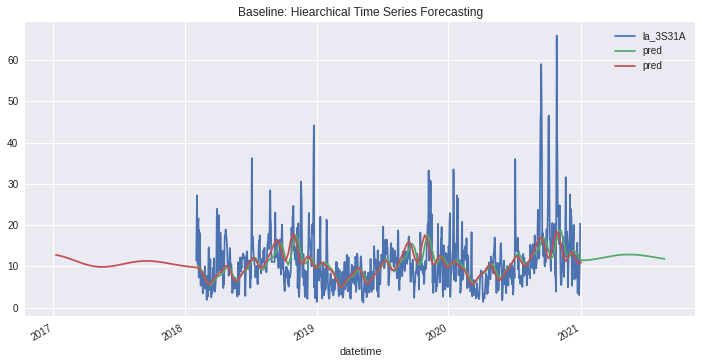

In [35]:
ax = train_labels[train_labels.grid_id=='3S31A'].pivot(index="datetime", columns="loc_grid", values="pm25").plot(label='actual');
ax = (models['la']['forecast']["la_3S31A"]/7).plot(label='pred'); 
ax = (models['la']['backcast']["la_3S31A"]/7).plot(label='pred'); 

ax.legend();
ax.set_title('Baseline: Hiearchical Time Series Forecasting')
plt.savefig(DATA_PATH / 'images/baseline.png');